# Implementing coordinate-transformed hermite polynomials

In [1]:
#  Automated import
import sys
import os
sys.path.append('..')

from hg_scripts.setup_imports import *



In [21]:
#expansion orders
sh_order = 1
ti_order = 5

#terms in xp matrix
xpfile = dict_from_xpfile('x_p_file')
sols_matrix = xpfile[str(sh_order)+'_shift_'+str(ti_order)+'_tilt']
# print(sols_matrix)
xpfile.clear()

In [3]:
xtran_file = build_symbolic_dictionary(n_max=40,p_max=10,x_max=10)

..\hg_scripts\transverse_coord_transform.py:142: RuntimeWarning: invalid value encountered in sqrt
  item.n_coeff += "*"+str(Sqrt(item.N+1))


In [12]:
#represents the sums
def update_modes (z,params,a,b,modes,sols_matrix):
    #get params
    K = params.getK()
    w0 = params.getW0()
    zr = params.getZr()
    w = pl.w(z,params)
    gouy = pl.gouy_phase(z,params) 
    R = pl.radius_curvature(z,params)
    
    #build new modes (up to 2 orders larger for quad. dep.)
    rows = len(modes)
    cols = len(modes[0])  
    number_modes = rows*cols
    exp_order = len(sols_matrix)
    new_modes = [[0 for m in range(cols+exp_order)] for n in range(rows+exp_order)]
    
    #placeholders
    x=1
    j=1j
    p=e**(1j*gouy)
    
    #calculate all coupling factors a->e\d
       
    for n in range(len(modes)):
        for m in range(len(modes[n])):
            if (modes[n][m]!=0): #break if c_nm = 0
                c_nm = modes[n][m] #assign c_nm

                for x_order in range(len(sols_matrix[0])):
                    for p_order in range(len(sols_matrix)):
                        if(sols_matrix[x_order][p_order]!='' and (p_order<=n) ):
                            #append each element in x,p matrix to coupling list
                            coupling = eval(sols_matrix[x_order][p_order])*(p**(p_order))
                            
                            if(x_order>0):
                                key = 'n'+str(n)+'p'+str(p_order)+'x'+str(x_order)
                                q = xtran_file[key]
                                #print(n_start,x_order)
                                #empty the q
                                for item in q:
                                    X = eval(item.overall) #just x coupling
                                    N = item.N #final n order
                                    #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                    if(N>=0):
                                        new_modes[N][m]+= c_nm*coupling*X

                            #N is either n or n-p_order, no x-dependence
                            else:
                                N= n-p_order
                                #print("N,x_order,p_order,n,m",N,x_order,p_order,n,m)
                                new_modes[N][m]+= c_nm*coupling                            
# return(new_modes,ind_list)
    return(new_modes)

In [13]:
# mat = scipy.io.loadmat('Top_hat_for_paul.mat')
mat = scipy.io.loadmat('paul_coef_file.mat')
for x in mat:
  print(x)
coef=mat['coeftopUnitInt'].ravel()
print(mat['readmepaul'])
# coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]
    
top_modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

params = pl.Params(1064e-9,.33e-3,0)
plane = pl.Plane(-2e-3,2e-3,101,-2e-3,2e-3,101)
# temp_modes=rotate_RX(10e-3,params,10e-3,0,modes)
# pl.show_modes(modes)
# calc=pl.calculate(params,plane,top_modes,0)
# #plot
# fig, ax = plt.subplots(figsize=(12, 12))
# cs = plt.contourf(calc.plane.getX(), calc.plane.getY(), abs(calc.getAmp() ** 2))

# ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

# plt.xlim([-1e-3,1e-3])
# plt.ylim([-1e-3,1e-3])

# cbar = fig.colorbar(cs)

# plt.grid()


__header__
__version__
__globals__
coeftopUnitInt
coeftopUnitPow
readmepaul
['Two tophat coefficient variables, one for unit power and one for \n unit intensity, should be clear from the name which is which.\nAgain these assume a waist 1/3 of a mm.']


In [14]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes,s):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,s) )
                
    return(res)

In [15]:


def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave1 = 0
    time_ave2 = 0
    
    s= (
        1/(v.w_1**2 *(1+(1j)*v.d_1/v.zR_1))
        +
        1/((v.w_2**2 *(1-(1j)*v.Z/v.zR_2)))
    )

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

    pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start1 = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],top_modes,sols_matrix)
        
        time_ave_start2 = process_time()
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes,s) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes,s) # right overlap (0,2e-3)
        time_ave1 += (process_time()-time_ave_start1)
        time_ave2 += (process_time()-time_ave_start2)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1
        
        pbar.update(p+1)
        
    pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave1/p,'s',time_ave2/p,'s')
    
    return(dws,lps,total_lps)

num=100
waist = (1/3)*1e-3
# waist = 1e-3

class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=10e-3,z=10e-3,
                 z_m=0,Z=10e-3,
                 z_LO=0, d_1=10e-3,
#                  z_PD=0,z=0,
#                  z_m=0,Z=0,
#                  z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1e-3,
                 points=num,
                 a=10e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],top_modes,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


Exception reporting mode: Verbose
Signals calculation...


100%|#########################################################################|


716.78125 s
7.238794191919192 s 1.3650568181818181 s


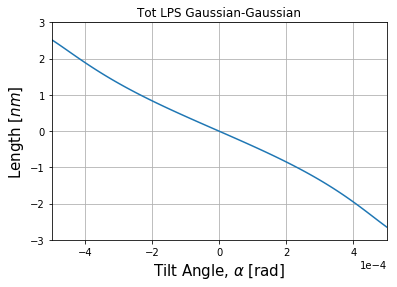

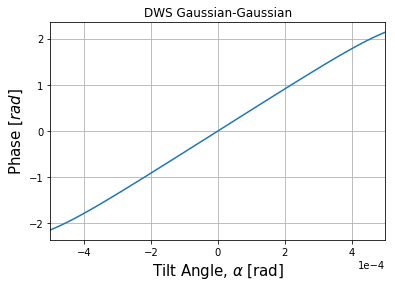

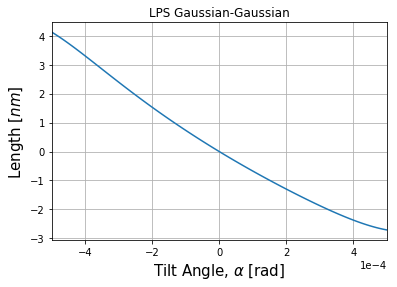

In [22]:
modes_0 = plb.modes((0,0,1))

%xmode Verbose

# z=10e-3
# params = pl.Params(1064e-9,1e-3,z)


print('Signals calculation...')
v = Vars()
dws,lps,total_lps = signals(v)


params=pl.Params(1064e-9,waist,0)
K=params.getK()

total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'Tot LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
plt.ylim([-3,3])
# plt.legend()
plt.plot(v.alpha_arr,total_arr_con)


plt.grid()

plt.figure()

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,dws)

plt.grid()

plt.figure()



plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,lps_arr_con)


plt.grid()